# 4. Optimus, Learning and Resource models, Performance-cost tradeoffs

## 4.1. 
Gathered data with the following students:

1. Tamanna Ananna, ta2642
2. David Heagy, dh2868
3. Viren Bajaj, vb2519
4. Ravish Rawal, rr2914

In [77]:
#!unzip -o resnet-history.zip

Archive:  resnet-history.zip
  inflating: resnet-history/resnet44-k80.csv  
  inflating: __MACOSX/resnet-history/._resnet44-k80.csv  
  inflating: resnet-history/resnet20-v100.csv  
  inflating: __MACOSX/resnet-history/._resnet20-v100.csv  
  inflating: resnet-history/resnet56-v100.csv  
  inflating: __MACOSX/resnet-history/._resnet56-v100.csv  
  inflating: resnet-history/resnet50-p100.csv  
  inflating: resnet-history/resnet18-p100.csv  
  inflating: __MACOSX/resnet-history/._resnet18-p100.csv  
  inflating: resnet-history/.DS_Store  
  inflating: __MACOSX/resnet-history/._.DS_Store  
  inflating: resnet-history/resnet18-k80.csv  
  inflating: __MACOSX/resnet-history/._resnet18-k80.csv  
  inflating: resnet-history/resnet56-p100.csv  
  inflating: __MACOSX/resnet-history/._resnet56-p100.csv  
  inflating: resnet-history/resnet20-p100.csv  
  inflating: __MACOSX/resnet-history/._resnet20-p100.csv  
  inflating: resnet-history/resnet56-k80.csv  
  inflating: __MACOSX/resnet-history/._r

In [78]:
#!ls resnet-history

resnet18-k80.csv   resnet32-k80.csv   resnet44-v100.csv  resnet56-p100.csv
resnet18-p100.csv  resnet32-p100.csv  resnet50-k80.csv	 resnet56-v100.csv
resnet18-v100.csv  resnet32-v100.csv  resnet50-p100.csv  results20-k80.csv
resnet20-p100.csv  resnet44-k80.csv   resnet50-v100.csv
resnet20-v100.csv  resnet44-p100.csv  resnet56-k80.csv


In [96]:
from os import listdir
from os.path import splitext, join

from scipy.optimize import curve_fit

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [90]:
data_dir = 'resnet-history'
files = listdir(data_dir)


history = {}

for file in files:
    file_info = splitext(file)
    if file_info[-1] == '.csv':
        results = pd.read_csv(join(data_dir, file))
        results['model'] = file_info[0]
        history[file_info[0]] = results
        
history.keys()

dict_keys(['resnet32-v100', 'resnet56-k80', 'resnet32-p100', 'resnet50-p100', 'resnet18-p100', 'resnet50-k80', 'resnet18-v100', 'resnet50-v100', 'resnet20-k80', 'resnet44-k80', 'resnet20-p100', 'resnet56-p100', 'resnet44-v100', 'resnet44-p100', 'resnet32-k80', 'resnet20-v100', 'resnet56-v100', 'resnet18-k80'])

In [91]:
history['resnet18-k80'].head()

,epoch,steps,training step,training data,training loss,training prec1,training prec5,training error1,training error5,validation step,validation data,validation loss,validation prec1,validation prec5,validation error1,validation error5,model
0,1,390,0.062469,0.005346,1.741367,33.671875,85.889423,66.328125,14.110577,0.038952,0.020096,1.608177,43.71,89.86,56.29,10.14,resnet18-k80
1,2,780,0.062429,0.005023,1.240431,54.196715,94.917869,45.803285,5.082131,0.038416,0.019594,1.424388,53.23,94.83,46.77,5.17,resnet18-k80
2,3,1170,0.063096,0.004628,1.014315,63.601763,96.786859,36.398237,3.213141,0.038704,0.020167,1.261538,57.89,96.00,42.11,4.00,resnet18-k80
3,4,1560,0.062571,0.005146,0.876357,68.918269,97.578125,31.081731,2.421875,0.038164,0.019761,1.382180,59.48,97.45,40.52,2.55,resnet18-k80
4,5,1950,0.062839,0.005385,0.776889,72.618189,98.191106,27.381811,1.808894,0.037872,0.019627,0.830184,72.44,97.65,27.56,2.35,resnet18-k80


In [92]:
# separate out data for resnet50

test_data_keys = {'resnet50-k80', 'resnet50-p100', 'resnet50-v100'}
test_history = {}

for model_key in test_data_keys:
    test_history[model_key] = history.pop(model_key)
    
test_history.keys()

dict_keys(['resnet50-v100', 'resnet50-p100', 'resnet50-k80'])

In [93]:
history.keys()

dict_keys(['resnet32-v100', 'resnet56-k80', 'resnet32-p100', 'resnet18-p100', 'resnet18-v100', 'resnet20-k80', 'resnet44-k80', 'resnet20-p100', 'resnet56-p100', 'resnet44-v100', 'resnet44-p100', 'resnet32-k80', 'resnet20-v100', 'resnet56-v100', 'resnet18-k80'])

In [142]:
# train Optimus model

def reciprocal(k, b0, b1, b2):
    return 1.0 / (b0 * k + b1) + b2
    #return b0 * k + b1 + (0.1*b2)

optimus = {}

for model_name, data in sorted(history.items()):
    b, _ = curve_fit(
        f = reciprocal,
        xdata = data['epoch'],
        ydata = data['training loss'],
        method = 'dogbox'
    )
        
    optimus[model_name] = b

optimus

{'resnet18-k80': array([0.09921311, 0.61705126, 0.01161551]),
 'resnet18-p100': array([0.09762673, 0.60343671, 0.01104587]),
 'resnet18-v100': array([0.09749865, 0.61529245, 0.01192984]),
 'resnet20-k80': array([ 0.10575643,  0.59098   , -0.01380867]),
 'resnet20-p100': array([ 0.10645679,  0.58647346, -0.01348943]),
 'resnet20-v100': array([ 0.10456577,  0.58398825, -0.01426793]),
 'resnet32-k80': array([ 0.11977595,  0.58632375, -0.02132834]),
 'resnet32-p100': array([ 0.12450782,  0.57423677, -0.02008377]),
 'resnet32-v100': array([ 0.11911155,  0.57889499, -0.02152496]),
 'resnet44-k80': array([ 0.12753544,  0.56916051, -0.02244776]),
 'resnet44-p100': array([ 0.12610666,  0.56854311, -0.02330288]),
 'resnet44-v100': array([ 0.13161286,  0.55370491, -0.02187052]),
 'resnet56-k80': array([ 0.13143774,  0.55681592, -0.02339022]),
 'resnet56-p100': array([ 0.13186931,  0.55311546, -0.02344347]),
 'resnet56-v100': array([ 0.13741466,  0.54408631, -0.02196343])}

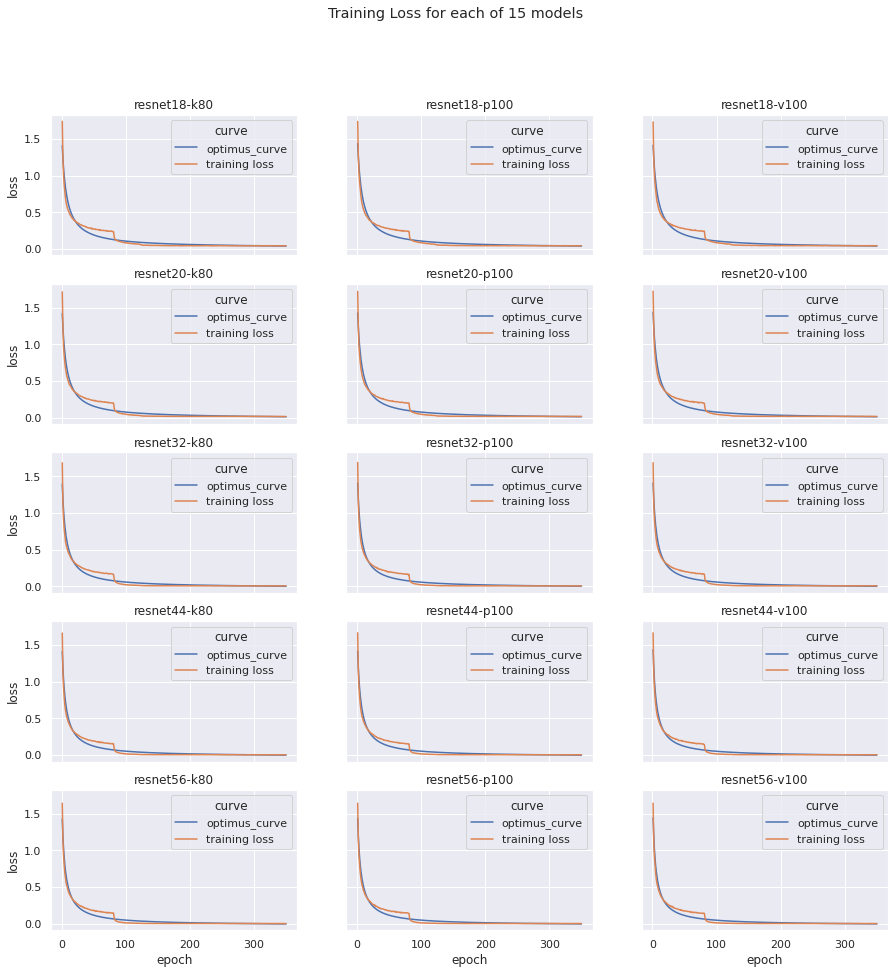

In [144]:
fig, axes = plt.subplots(5, 3, figsize = (15, 15), sharex = True, sharey = True)


for (model, results), (modelo, b), ax in zip(sorted(history.items()), sorted(optimus.items()), axes.reshape(-1)):
    assert model == modelo
    
    results = results.assign(optimus_curve = lambda x: reciprocal(x.epoch, b[0], b[1], b[2]))
    results = pd.melt(
        results, 
        id_vars = ['epoch'], 
        value_vars = ['optimus_curve', 'training loss'],
        var_name = 'curve',
        value_name = 'loss')
    
    sns.lineplot(ax = ax, data = results, x = 'epoch', y = 'loss', hue = 'curve')
    ax.title.set_text(model)
fig.suptitle('Training Loss for each of 15 models')
plt.ylim
plt.show()